# RNN Zeitreihenvorhersage

### Lernen und vorhersagen von Zeitreihen

Als erstes wird hier alles nötige importiert (wir verwenden hier Tensorflow ohne kein Keras) und ein paar Einstellungen werden vorgenommen:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import tensorflow as tf

# Zeitreihen erstellen und trainieren

Zunächst wird eine einfache Zeitreihe (aus Sinusfunktionen) erstellt und in batches aufgeteilt

In [2]:
t_min, t_max = 0, 30
resolution = 0.1

#Die Zeitreihe, die erlernt und vorhergesagt werden soll
def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

#Erstellt zufällige batches aus der Zeitreihe
def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

In [3]:
#Plotten der Funktion und der Trainingsdaten
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

## Trainieren des Netzes

Es wird ein RNN erstellt mit:
- 1 Eingabeneuron (erhällt nur den skalaren Wert für jeden Zeitschritt; es werden 20 Zeitschritte als Eingabe verwendet)
- 100 Rekurente Neuronen als Hidden-Layer
- 1 Ausgabeneuron (das die Ausgabe zum nächsten Zeitpunkt liefern soll)

In [4]:
#mögliche früher erstellte Graphen werden gelöscht
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

learning_rate = 0.001

#Die Placeholder sind in Tensorflow dazu da, die Eingaben (X Matrix) und die Ausgaben (y Vektor) im Graphen zu modellieren
#Die Placeholder werden im Training und in der Ausführung durch die Werte des Datensatzes ersetzt
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

#Hidden-Layer erstellen
cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

#Die outputs des Netzes als inputs verwenden, damit es eine eigene Zeitreihe erstellen kann
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

#loss funktion erstellen (verwendet den Mittleren-Quadratischen-Fehler MSE) und modell trainieren (mit einem AdamsOptimierer)
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

#zum speichern des Modells
saver = tf.train.Saver()

#Das Netz wird über 1500 iterationen trainiert
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration + 100, "\tMSE:", mse)
    
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    
    saver.save(sess, "./my_time_series_model")

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dense instead.
100 	MSE: 13.907029
200 	MSE: 0.5056698
300 	MSE: 0.19735886
400 	MSE: 0.101214476
500 	MSE: 0.06850145
600 	MSE: 0.06291986
700 	MSE: 0.055129297
800 	MSE: 0.049436502
900 	MSE: 0.050434686
1000 	MSE: 0.0482007
1100 	MSE: 0.04809868
1200 	MSE: 0.04982501
1300 	MSE: 0.041912545
1400 	MSE: 0.049292978
1500 	MSE: 0.043140374


### Testen des Modells

Das Modell wird durch den Berechneten Mean-Square-Error getestet, kann aber auch durch die geplottete Vorhersage getestet werden.

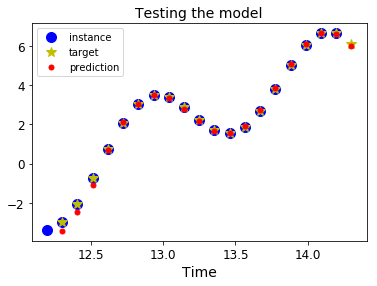

In [5]:
#Vorhersage des Modells plotten
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "y*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

In [6]:
#Modell laden und eine eigene "kreative" Zeitreihe erzeugen
with tf.Session() as sess:
    saver.restore(sess, "./my_time_series_model")
    
    #Die Eingabedaten (zum Starten der Sequenz) sind nur Nullen
    sequence = [0.] * n_steps
    for iteration in range(300):
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence.append(y_pred[0, -1, 0])

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./my_time_series_model


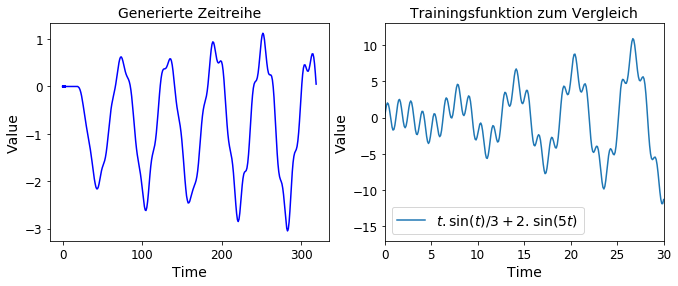

In [7]:
#Ausgabesequenz plotten
plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(np.arange(len(sequence)), sequence, "b-")
plt.plot(t[:n_steps], sequence[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Generierte Zeitreihe", fontsize=14)

#Zum Vergleich: Die Trainingsfunktion
plt.subplot(122)
plt.title("Trainingsfunktion zum Vergleich", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.show()

### Ergebniss:

Der erstellte Plot sieht der Trainierten Sinusfunktion nur halbwegs ähnlich. Das liegt vermutlich daran, das die Eingabedaten (20 Nullen) für das Trainierte modell wenig Sinn ergeben.

Als nächstes wird zum Vergleich eine Eingabe getestet, die der Trainierten Funktion ähnlicher ist.

INFO:tensorflow:Restoring parameters from ./my_time_series_model


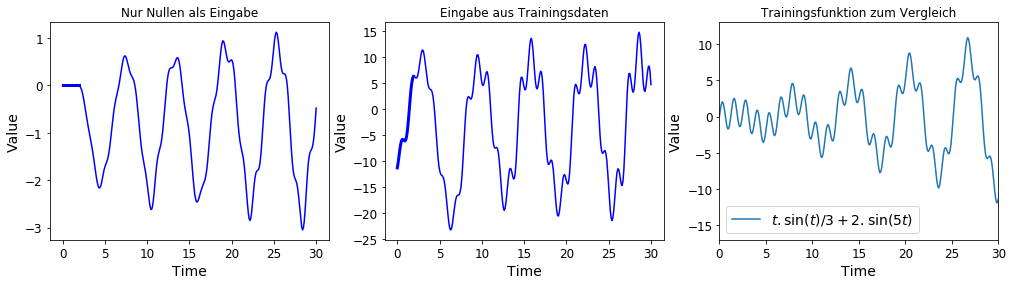

In [8]:
with tf.Session() as sess:
    saver.restore(sess, "./my_time_series_model")
    
    #Erste Sequenz: besteht wie vorher nur aus Nullen
    sequence1 = [0. for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence1[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence1.append(y_pred[0, -1, 0])
    
    #Zweite Sequenz: besteht aus Eingabedaten, wie sie auch in der Trainingsfunktion vorkahmen
    sequence2 = [time_series(i * resolution + t_min + (t_max-t_min/3)) for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence2[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence2.append(y_pred[0, -1, 0])

#Nur Nullen als Eingabe
plt.figure(figsize=(17,4))
plt.subplot(131)
plt.plot(t, sequence1, "b-")
plt.plot(t[:n_steps], sequence1[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Nur Nullen als Eingabe")

#Eingabe aus Trainingsdaten
plt.subplot(132)
plt.plot(t, sequence2, "b-")
plt.plot(t[:n_steps], sequence2[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Eingabe aus Trainingsdaten")

#Zum Vergleich: Die Trainingsfunktion
plt.subplot(133)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Trainingsfunktion zum Vergleich")

plt.show()

### Ergebniss:

Mit sinnvollen (bzw. bekannt erscheinenden) Starteingaben sieht die frei generierte Zeitreihe der Trainingsfunktion schon ähnlicher.